In [187]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import holidays

In [188]:
# Load your time series data
df = pd.read_csv('LSTM Dataset.csv')
df.tail(5)

,Day,Date,Time,DateAndTime,Entry,is_weekend,rain_class,rain_amount,rain_desc
14595,Sunday,12/31/2023,19:00,31.12.2023 19.00.00,1681.0,1,0,0.0,No Rain
14596,Sunday,12/31/2023,20:00,31.12.2023 20.00.00,297.0,1,0,0.0,No Rain
14597,Sunday,12/31/2023,21:00,31.12.2023 21.00.00,0.0,1,0,0.0,No Rain
14598,Sunday,12/31/2023,22:00,31.12.2023 22.00.00,0.0,1,0,0.0,No Rain
14599,Sunday,12/31/2023,23:00,31.12.2023 23.00.00,0.0,1,0,0.0,No Rain


In [189]:
ph_holidays = holidays.PH()
df['is_holiday'] = df['Date'].apply(lambda x: 1 if x in ph_holidays else 0)
df.head(5)

,Day,Date,Time,DateAndTime,Entry,is_weekend,rain_class,rain_amount,rain_desc,is_holiday
0,Saturday,1/1/2022,4:00,01.01.2022 04.00.00,0.0,1,0,0.0,No Rain,1
1,Saturday,1/1/2022,5:00,01.01.2022 05.00.00,0.0,1,0,0.0,No Rain,1
2,Saturday,1/1/2022,6:00,01.01.2022 06.00.00,525.0,1,0,0.0,No Rain,1
3,Saturday,1/1/2022,7:00,01.01.2022 07.00.00,610.0,1,0,0.0,No Rain,1
4,Saturday,1/1/2022,8:00,01.01.2022 08.00.00,684.0,1,0,0.0,No Rain,1


In [190]:
df.drop(['Date', 'Time', 'rain_amount', 'rain_desc'], axis=1, inplace=True)
df.head(31)

,Day,DateAndTime,Entry,is_weekend,rain_class,is_holiday
0,Saturday,01.01.2022 04.00.00,0.0,1,0,1
1,Saturday,01.01.2022 05.00.00,0.0,1,0,1
2,Saturday,01.01.2022 06.00.00,525.0,1,0,1
3,Saturday,01.01.2022 07.00.00,610.0,1,0,1
4,Saturday,01.01.2022 08.00.00,684.0,1,0,1
5,Saturday,01.01.2022 09.00.00,770.0,1,0,1
6,Saturday,01.01.2022 10.00.00,1022.0,1,0,1
7,Saturday,01.01.2022 11.00.00,1248.0,1,0,1
8,Saturday,01.01.2022 12.00.00,1048.0,1,0,1
9,Saturday,01.01.2022 13.00.00,1199.0,1,0,1


In [191]:
df['Date Time'] = pd.to_datetime(df['DateAndTime'], format='%d.%m.%Y %H.%M.%S')
df['hour'] = df['Date Time'].dt.hour
df['day_of_week'] = df['Date Time'].dt.dayofweek
df['month'] = df['Date Time'].dt.month
df['year'] = df['Date Time'].dt.year
df.drop(['DateAndTime', 'Day', 'is_weekend'], axis=1, inplace=True)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

model_features = ['hour', 'day_of_week', 'is_weekend', 'month', 'year', 'rain_class', 'Entry']
df_model = df[model_features]

df.head(50)

,Entry,rain_class,is_holiday,Date Time,hour,day_of_week,month,year,is_weekend
0,0.0,0,1,2022-01-01 04:00:00,4,5,1,2022,1
1,0.0,0,1,2022-01-01 05:00:00,5,5,1,2022,1
2,525.0,0,1,2022-01-01 06:00:00,6,5,1,2022,1
3,610.0,0,1,2022-01-01 07:00:00,7,5,1,2022,1
4,684.0,0,1,2022-01-01 08:00:00,8,5,1,2022,1
5,770.0,0,1,2022-01-01 09:00:00,9,5,1,2022,1
6,1022.0,0,1,2022-01-01 10:00:00,10,5,1,2022,1
7,1248.0,0,1,2022-01-01 11:00:00,11,5,1,2022,1
8,1048.0,0,1,2022-01-01 12:00:00,12,5,1,2022,1
9,1199.0,0,1,2022-01-01 13:00:00,13,5,1,2022,1


In [192]:
# Display the DataFrame before normalization
print(df_model.dtypes)
df_model.head(5)


hour             int32
day_of_week      int32
is_weekend       int64
month            int32
year             int32
rain_class       int64
Entry          float64
dtype: object


,hour,day_of_week,is_weekend,month,year,rain_class,Entry
0,4,5,1,1,2022,0,0.0
1,5,5,1,1,2022,0,0.0
2,6,5,1,1,2022,0,525.0
3,7,5,1,1,2022,0,610.0
4,8,5,1,1,2022,0,684.0


In [193]:
from sklearn.preprocessing import MinMaxScaler
import joblib
# Normalize all features except 'Entry'
scaler = MinMaxScaler(feature_range=(0, 1))
df_model[df_model.columns[:-1]] = scaler.fit_transform(df_model[df_model.columns[:-1]])

# Save the scaler for the features
joblib.dump(scaler, 'model/scaler_features.pkl')

# Normalize the 'Entry' column separately
scaler_entry = MinMaxScaler(feature_range=(0, 1))
df_model['Entry'] = scaler_entry.fit_transform(df_model[['Entry']])
 
# Save the scaler for the 'Entry' column
joblib.dump(scaler_entry, 'model/scaler_entry.pkl')

# Display the DataFrame after normalization
print("After normalization:")
print(df_model.head())
print(df_model.dtypes)

After normalization:
       hour  day_of_week  is_weekend  month  year  rain_class     Entry
0  0.000000     0.833333         1.0    0.0   0.0         0.0  0.000000
1  0.052632     0.833333         1.0    0.0   0.0         0.0  0.000000
2  0.105263     0.833333         1.0    0.0   0.0         0.0  0.082121
3  0.157895     0.833333         1.0    0.0   0.0         0.0  0.095417
4  0.210526     0.833333         1.0    0.0   0.0         0.0  0.106992
hour           float64
day_of_week    float64
is_weekend     float64
month          float64
year           float64
rain_class     float64
Entry          float64
dtype: object


C:\Users\inspiron-7460\AppData\Local\Temp\ipykernel_15668\1478980868.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\inspiron-7460\AppData\Local\Temp\ipykernel_15668\1478980868.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

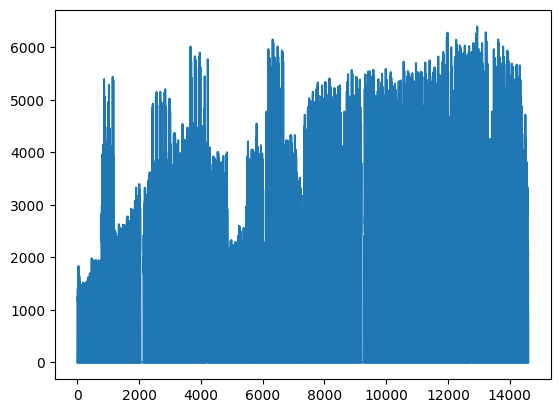

In [194]:
entry = df['Entry']
entry.plot()

In [195]:
def df_to_X_y(df, window_size=19):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size][6]  # 'Entry' is the 7th column (index 6)
        y.append(label)
    return np.array(X), np.array(y)

In [196]:
X, y = df_to_X_y(df_model)
X.shape, y.shape

((14581, 19, 7), (14581,))

In [197]:
# Determine the split points
train_split_point = int(len(X) * 0.8)
valntest_split_point = int(len(X) * 0.9)

# Split the data
X_train, X_val, X_test = X[:train_split_point], X[train_split_point:valntest_split_point], X[valntest_split_point:]
y_train, y_val, y_test = y[:train_split_point], y[train_split_point:valntest_split_point], y[valntest_split_point:]

# Print the shapes to verify the splits
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11664, 19, 7), (11664,), (1458, 19, 7), (1458,), (1459, 19, 7), (1459,))

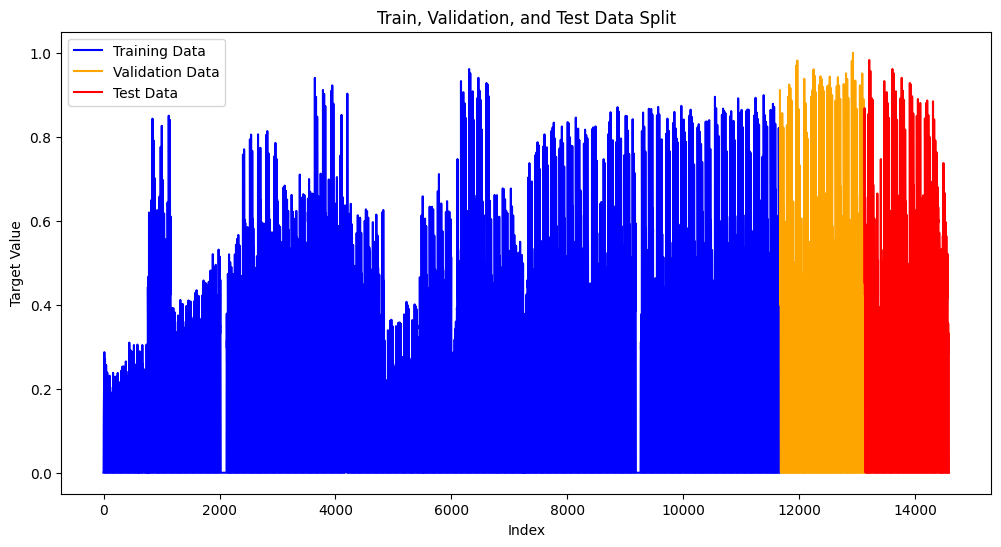

In [198]:
import matplotlib.pyplot as plt
# Visualization

date_time = df['Date Time']
plt.figure(figsize=(12, 6))

# Plot the training data
plt.plot(range(train_split_point), y_train, label='Training Data', color='blue')

# Plot the validation data
plt.plot(range(train_split_point, valntest_split_point), y_val, label='Validation Data', color='orange')

# Plot the test data
plt.plot(range(valntest_split_point, len(X)), y_test, label='Test Data', color='red')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Train, Validation, and Test Data Split')
plt.legend()

# Show the plot
plt.show()

In [199]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [200]:
model = Sequential()
model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 19, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

In [201]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the ModelCheckpoint callback with the correct file path
os.makedirs('model', exist_ok=True)
cp1 = ModelCheckpoint(filepath='model/best_lstm.keras', save_best_only=True, monitor='val_loss', mode='min')

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, early_stopping])


Epoch 1/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 74s 32ms/step - loss: 0.0355 - val_loss: 0.0121
Epoch 2/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 3/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 4/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0045 - val_loss: 0.0075
Epoch 5/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 6/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 7/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 8/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 9/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 10/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 11/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 12/100
365/365

In [202]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go

# Extract the 'Date Time' column for the test set
date_time_test = df['Date Time'][-len(y_test):]  # Use the date time series for the test set

# Load the scaler for inverse transformation
scaler_entry = joblib.load('model/scaler_entry.pkl')

# Make predictions on the test dataset
y_pred = model.predict(X_test)

# Check the length of y_pred to ensure it matches y_test
print(f"Length of y_pred: {len(y_pred)}")
print(f"Length of y_test: {len(y_test)}")

# Inverse transform the predictions and actual values
# Create a DataFrame to hold the predictions and actual values
df_pred = pd.DataFrame(y_pred, columns=['Entry'])
df_actual = pd.DataFrame(y_test, columns=['Entry'])

# Inverse transform the 'Entry' column
y_pred_inv = scaler_entry.inverse_transform(df_pred)
y_true_inv = scaler_entry.inverse_transform(df_actual)

# Round the predictions to the nearest whole number and ensure non-negative values
y_pred_inv = np.round(np.maximum(y_pred_inv, 0))
y_true_inv = np.round(np.maximum(y_true_inv, 0))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# Plot the results with 'Date Time' as the x-axis using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=date_time_test, y=y_true_inv.flatten(), mode='lines', name='Actual Test Values'))
fig.add_trace(go.Scatter(x=date_time_test, y=y_pred_inv.flatten(), mode='lines', name='Forecasted Values'))

fig.update_layout(title='LSTM Model Forecast vs Actual Test Values', xaxis_title='Date Time', yaxis_title='Entry', legend_title='Legend')

fig.show()

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Length of y_pred: 1459
Length of y_test: 1459
Root Mean Squared Error (RMSE): 312.2500206470859
Mean Absolute Error (MAE): 183.4804660726525
R-squared (R²): 0.9467905156575819


In [203]:
print(f"Length of the dataset: {len(X)}")

# Make predictions on the entire dataset
y_pred = model.predict(X)

# Inverse transform the predictions and actual values
# Create a DataFrame to hold the predictions and actual values
df_pred = pd.DataFrame(y_pred, columns=['Entry'])
df_actual = pd.DataFrame(y, columns=['Entry'])

# Inverse transform the 'Entry' column
y_pred_inv = scaler_entry.inverse_transform(df_pred)
y_true_inv = scaler_entry.inverse_transform(df_actual)

# Round the predictions to the nearest whole number and ensure non-negative values
y_pred_inv = np.round(np.maximum(y_pred_inv, 0))
y_true_inv = np.round(np.maximum(y_true_inv, 0))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# Create a DataFrame with all features and the true and forecasted values
df_features_with_predictions = df.iloc[-len(y_true_inv):].copy()

# Rename the 'Entry' column to 'Actual Values'
df_features_with_predictions.rename(columns={'Entry': 'Actual Values'}, inplace=True)

# Add the 'Forecasted Values' column
df_features_with_predictions['Forecasted Values'] = y_pred_inv.flatten()

# Reorder the columns
df_features_with_predictions = df_features_with_predictions[['Date Time', 'hour', 'day_of_week', 'is_weekend', 'is_holiday', 'month', 'year', 'rain_class', 'Actual Values', 'Forecasted Values']]

# Plot the results with 'Date Time' as the x-axis using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_features_with_predictions['Date Time'], y=df_features_with_predictions['Actual Values'], mode='lines', name='Actual Values'))
fig.add_trace(go.Scatter(x=df_features_with_predictions['Date Time'], y=df_features_with_predictions['Forecasted Values'], mode='lines', name='Forecasted Values'))

fig.update_layout(title='LSTM Model Forecast vs Actual Values', xaxis_title='Date Time', yaxis_title='Entry', legend_title='Legend')

fig.show()

Length of the dataset: 14581
456/456 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
Root Mean Squared Error (RMSE): 226.4387023154753
Mean Absolute Error (MAE): 145.20629586448118
R-squared (R²): 0.9698561191004021


In [204]:
import plotly.express as px

# Group the data by hour and calculate the mean for Actual Values and Forecasted Values
hourly_trends = df_features_with_predictions.groupby('hour')[['Actual Values', 'Forecasted Values']].mean().reset_index()

# Display the hourly trends DataFrame
print(hourly_trends)

# Plot the hourly trends using Plotly
fig = px.line(hourly_trends, x='hour', y=['Actual Values', 'Forecasted Values'], title='Hourly Trends of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Entry',
    legend_title='Legend'
)

# Show the plot
fig.show()

    hour  Actual Values  Forecasted Values
0      4      13.554184          77.681755
1      5    1992.597165        2071.351074
2      6    3063.263603        3111.980713
3      7    3670.468907        3709.795654
4      8    3230.871056        3279.650146
5      9    2801.925926        2755.292236
6     10    2414.137860        2552.083740
7     11    2397.104024        2420.181152
8     12    2385.529721        2380.392334
9     13    2299.090992        2349.540527
10    14    2290.140832        2326.155029
11    15    2425.228624        2434.711914
12    16    2794.812757        2747.422607
13    17    3113.893004        3077.332031
14    18    2990.024234        3066.421143
15    19    2714.909465        2676.565186
16    20    2218.021491        2235.888916
17    21    1572.274577        1655.821655
18    22      84.217421         115.082306
19    23       9.768721          75.632874


In [205]:
# Group the data by day of the week and calculate the mean for Actual Values and Forecasted Values
daily_trends = df_features_with_predictions.groupby('day_of_week')[['Actual Values', 'Forecasted Values']].mean().reset_index()

# Sort the daily trends DataFrame to start with Sunday
daily_trends['day_of_week'] = daily_trends['day_of_week'].map({6: 'Sunday', 0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday'})
daily_trends = daily_trends.set_index('day_of_week').reindex(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']).reset_index()

# Plot the daily trends using Plotly
fig = px.line(daily_trends, x='day_of_week', y=['Actual Values', 'Forecasted Values'], title='Daily Trends of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Entry',
    legend_title='Legend',
    xaxis=dict(
        tickmode='array',
        tickvals=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
        ticktext=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    )
)

# Show the plot
fig.show()

In [206]:
import pandas as pd
import plotly.express as px

# Group the data by month and calculate the mean for Actual Values and Forecasted Values
yearly_trends = df_features_with_predictions.groupby('month')[['Actual Values', 'Forecasted Values']].mean().reset_index()

# Map the month numbers to month names
yearly_trends['month'] = yearly_trends['month'].map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

# Sort the DataFrame by month order
yearly_trends['month'] = pd.Categorical(yearly_trends['month'], categories=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
], ordered=True)
yearly_trends = yearly_trends.sort_values('month')

# Plot the yearly trends using Plotly
fig = px.line(yearly_trends, x='month', y=['Actual Values', 'Forecasted Values'], title='Yearly Trends of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Entry',
    legend_title='Legend',
    xaxis=dict(
        tickmode='array',
        tickvals=[
            'January', 'February', 'March', 'April', 'May', 'June',
            'July', 'August', 'September', 'October', 'November', 'December'
        ],
        ticktext=[
            'January', 'February', 'March', 'April', 'May', 'June',
            'July', 'August', 'September', 'October', 'November', 'December'
        ]
    )
)

# Show the plot
fig.show()

In [207]:
# DO NOT RUN THIS!
'''from sklearn.model_selection import TimeSeriesSplit
# Cross-Validation
def time_series_cv(df_model, n_splits=5, window_size=19):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    all_rmse = []
    all_mae = []
    all_r2 = []
    
    for train_index, val_index in tscv.split(df_model):
        df_train, df_val = df_model.iloc[train_index], df_model.iloc[val_index]
        
        # Prepare data
        X_train, y_train = df_to_X_y(df_train, window_size)
        X_val, y_val = df_to_X_y(df_val, window_size)
        
        # Build the model
        model = Sequential()
        model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(64))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='linear'))
        model.add(Dense(1, activation='linear'))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Fit the model
        model.fit(X_train, y_train, epochs=100, verbose=0)

        # Make predictions
        y_pred = model.predict(X_val)

        # Inverse transform the predictions and actual values
        df_pred = pd.DataFrame(y_pred, columns=['Entry'])
        df_actual = pd.DataFrame(y_val, columns=['Entry'])
        y_pred_inv = scaler_entry.inverse_transform(df_pred)
        y_true_inv = scaler_entry.inverse_transform(df_actual)

        # Round the predictions to the nearest whole number
        y_pred_inv = np.round(np.maximum(y_pred_inv, 0))
        y_true_inv = np.round(np.maximum(y_true_inv, 0))

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
        mae = mean_absolute_error(y_true_inv, y_pred_inv)
        r2 = r2_score(y_true_inv, y_pred_inv)

        all_rmse.append(rmse)
        all_mae.append(mae)
        all_r2.append(r2)

    return all_rmse, all_mae, all_r2

# Perform Time Series Cross-Validation
rmse_list, mae_list, r2_list = time_series_cv(df_model)

# Print the results
print("RMSE for each fold:", rmse_list)
print("Mean RMSE:", np.mean(rmse_list))
print("MAE for each fold:", mae_list)
print("Mean MAE:", np.mean(mae_list))
print("R-squared for each fold:", r2_list)
print("Mean R²:", np.mean(r2_list))'''

'from sklearn.model_selection import TimeSeriesSplit\n# Cross-Validation\ndef time_series_cv(df_model, n_splits=5, window_size=19):\n    tscv = TimeSeriesSplit(n_splits=n_splits)\n    \n    all_rmse = []\n    all_mae = []\n    all_r2 = []\n    \n    for train_index, val_index in tscv.split(df_model):\n        df_train, df_val = df_model.iloc[train_index], df_model.iloc[val_index]\n        \n        # Prepare data\n        X_train, y_train = df_to_X_y(df_train, window_size)\n        X_val, y_val = df_to_X_y(df_val, window_size)\n        \n        # Build the model\n        model = Sequential()\n        model.add(InputLayer((X_train.shape[1], X_train.shape[2])))\n        model.add(LSTM(64, return_sequences=True))\n        model.add(Dropout(0.2))\n        model.add(LSTM(64))\n        model.add(Dropout(0.2))\n        model.add(Dense(32, activation=\'linear\'))\n        model.add(Dense(1, activation=\'linear\'))\n\n        # Compile the model\n        model.compile(optimizer=\'adam\', loss=

In [208]:
# Calculate mean and standard deviation for holidays and non-holidays
mean_holiday = df[df['is_holiday'] == 1]['Entry'].mean()
std_holiday = df[df['is_holiday'] == 1]['Entry'].std()
mean_non_holiday = df[df['is_holiday'] == 0]['Entry'].mean()
std_non_holiday = df[df['is_holiday'] == 0]['Entry'].std()

print(f"Holiday - Mean: {mean_holiday}, Std Dev: {std_holiday}")
print(f"Non-Holiday - Mean: {mean_non_holiday}, Std Dev: {std_non_holiday}")

Holiday - Mean: 1566.4734126976225, Std Dev: 1204.845559602335
Non-Holiday - Mean: 2262.230559593546, Std Dev: 1299.610236071554


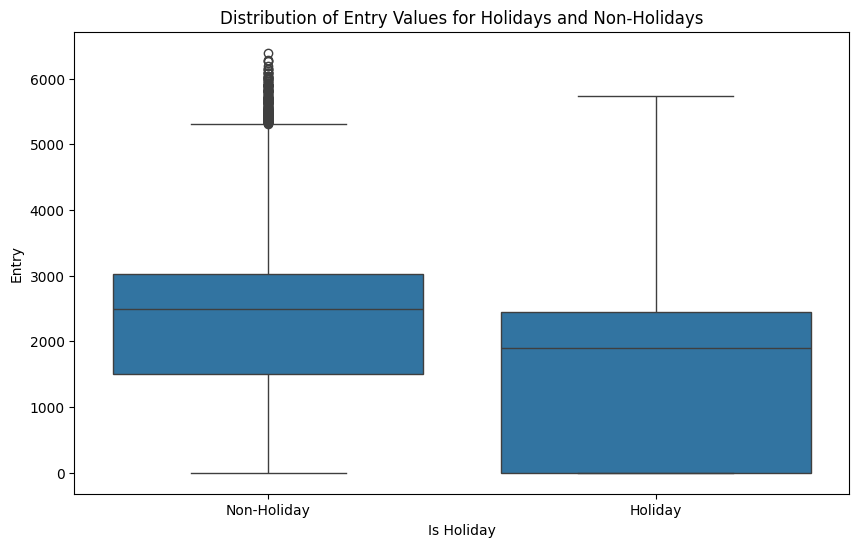

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot to visualize the distribution of Entry values for holidays and non-holidays
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_holiday', y='Entry', data=df)
plt.title('Distribution of Entry Values for Holidays and Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Entry')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

In [210]:
from scipy.stats import ttest_ind

# Perform t-test
holiday_entries = df[df['is_holiday'] == 1]['Entry']
non_holiday_entries = df[df['is_holiday'] == 0]['Entry']

t_stat, p_value = ttest_ind(holiday_entries, non_holiday_entries, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in Entry values between holidays and non-holidays.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Entry values between holidays and non-holidays.")

T-statistic: -16.172073238245833, P-value: 3.2099421304437347e-52
Reject the null hypothesis: There is a significant difference in Entry values between holidays and non-holidays.


In [211]:
# Calculate mean and standard deviation for each rain_class
rain_class_stats = df.groupby('rain_class')['Entry'].agg(['mean', 'std']).reset_index()
print(rain_class_stats)

   rain_class         mean          std
0           0  2145.033235  1300.077212
1           1  2189.014583  1294.567424
2           2  2384.725820  1307.742238
3           3  2244.148837  1302.094956
4           4  2103.780864  1270.273438
5           5  1112.050000   613.758265


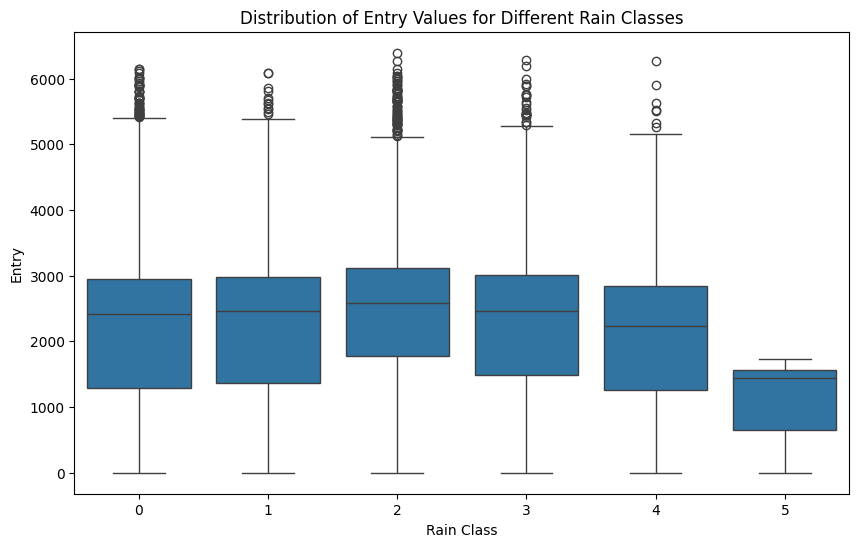

F-statistic: 20.975342571662864, P-value: 5.907390644949e-21
Reject the null hypothesis: There is a significant difference in Entry values between different rain classes.


In [212]:
# Box plot to visualize the distribution of Entry values for different rain classes
plt.figure(figsize=(10, 6))
sns.boxplot(x='rain_class', y='Entry', data=df)
plt.title('Distribution of Entry Values for Different Rain Classes')
plt.xlabel('Rain Class')
plt.ylabel('Entry')
plt.show()

from scipy.stats import f_oneway

# Perform ANOVA
rain_class_groups = [df[df['rain_class'] == rc]['Entry'] for rc in df['rain_class'].unique()]
f_stat, p_value = f_oneway(*rain_class_groups)

print(f"F-statistic: {f_stat}, P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in Entry values between different rain classes.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Entry values between different rain classes.")

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
     0      1    43.9813 0.8164    -56.992  144.9547  False
     0      2   239.6926    0.0    164.987  314.3982   True
     0      3    99.1156 0.0538    -0.9123  199.1435  False
     0      4   -41.2524 0.9808  -206.9189  124.4142  False
     0      5 -1032.9832 0.0052 -1862.6727 -203.2938   True
     1      2   195.7112    0.0    87.4189  304.0035   True
     1      3    55.1343  0.819   -71.9558  182.2243  False
     1      4   -85.2337  0.771  -268.5141   98.0466  False
     1      5 -1076.9646 0.0032 -1910.3498 -243.5794   True
     2      3   -140.577 0.0026  -247.9883  -33.1656   True
     2      4   -280.945    0.0  -451.1713 -110.7186   True
     2      5 -1272.6758 0.0002 -2103.2878 -442.0639   True
     3      4   -140.368 0.2428  -323.1292   42.3933  False
     3      5 -1132.0988 0.0015   -1965.

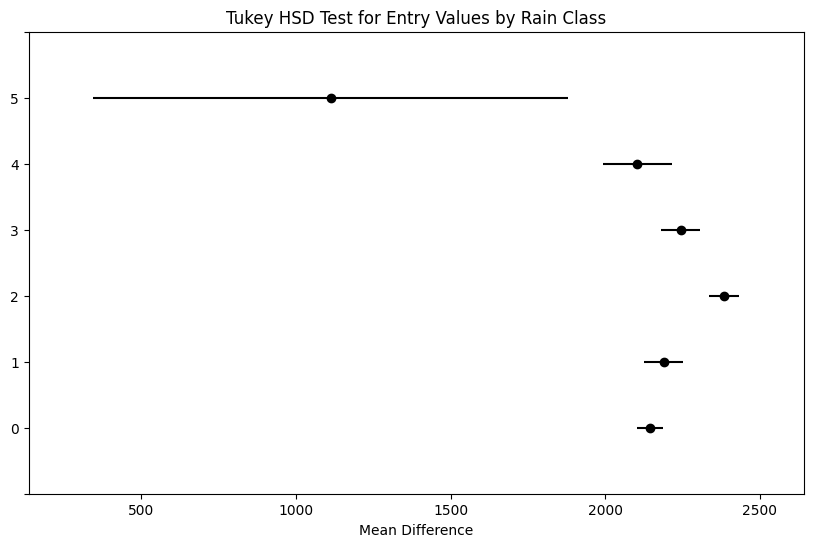

In [213]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['Entry'], groups=df['rain_class'], alpha=0.05)
print(tukey)

# Plot the results
tukey.plot_simultaneous()
plt.title('Tukey HSD Test for Entry Values by Rain Class')
plt.xlabel('Mean Difference')
plt.show()

In [214]:
#XAI
'''import shap
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Define the ModelCheckpoint callback with the correct file path
os.makedirs('model', exist_ok=True)
cp1 = ModelCheckpoint(filepath='model/best_lstm.keras', save_best_only=True, monitor='val_loss', mode='min')

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, early_stopping])'''



Epoch 1/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 2/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 3/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 7/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 11/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 12/100
365/36